<a href="https://colab.research.google.com/github/reekithak/Tuberculosis-CNN/blob/master/New_segmentation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
from google.colab import drive 
drive.mount('/content/gdirve')
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdirve/My Drive/Kaggle"


Drive already mounted at /content/gdirve; to attempt to forcibly remount, call drive.mount("/content/gdirve", force_remount=True).


In [0]:
from numpy.random import seed
seed(101)



import pandas as pd
import numpy as np

import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import binary_accuracy

import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Total number of images we want to have in each class
NUM_AUG_IMAGES_WANTED = 1000 

# We will resize the images
IMAGE_HEIGHT = 96
IMAGE_WIDTH = 96

In [67]:
%ls

ChinaSet_AllFiles/  model.h5     pulmonary-chest-xray-abnormalities.zip
kaggle.json         Montgomery/


In [68]:
print(len(os.listdir('/content/gdirve/My Drive/Kaggle/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')))
print(len(os.listdir('/content/gdirve/My Drive/Kaggle/Montgomery/MontgomerySet/CXR_png')))


663
139


In [0]:
shen_image_list = os.listdir('/content/gdirve/My Drive/Kaggle/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')
mont_image_list = os.listdir('/content/gdirve/My Drive/Kaggle/Montgomery/MontgomerySet/CXR_png')

In [70]:
# put the images into dataframes
df_shen = pd.DataFrame(shen_image_list, columns=['image_id'])
df_mont = pd.DataFrame(mont_image_list, columns=['image_id'])

# remove the 'Thunbs.db' line
df_shen = df_shen[df_shen['image_id'] != 'Thumbs.db']
df_mont = df_mont[df_mont['image_id'] != 'Thumbs.db']

# Reset the index or this will cause an error later
df_shen.reset_index(inplace=True, drop=True)
df_mont.reset_index(inplace=True, drop=True)

print(df_shen.shape)
print(df_mont.shape)

(662, 1)
(138, 1)


In [71]:
df_shen.head()

,image_id
0,CHNCXR_0001_0.png
1,CHNCXR_0002_0.png
2,CHNCXR_0003_0.png
3,CHNCXR_0004_0.png
4,CHNCXR_0005_0.png


In [72]:
df_mont.head()


,image_id
0,MCUCXR_0001_0.png
1,MCUCXR_0002_0.png
2,MCUCXR_0003_0.png
3,MCUCXR_0004_0.png
4,MCUCXR_0005_0.png


In [0]:
# Function to select the 4th index from the end of the string (file name)
# example: CHNCXR_0470_1.png --> 1 is the label, meaning TB is present.

def extract_target(x):
    target = int(x[-5])
    if target == 0:
        return 'Normal'
    if target == 1:
        return 'Tuberculosis'

In [0]:
df_shen['target'] = df_shen['image_id'].apply(extract_target)

df_mont['target'] = df_mont['image_id'].apply(extract_target)

In [75]:
# Shenzen Dataset

df_shen['target'].value_counts()

Tuberculosis    336
Normal          326
Name: target, dtype: int64

In [76]:
# Montgomery Dataset

df_mont['target'].value_counts()

Normal          80
Tuberculosis    58
Name: target, dtype: int64

In [0]:
try:
    from PIL import *
except AttributeError: #module has no attribute ImageN
    import Image
    import ImageDraw
    import ImageFont

In [87]:
df_data = pd.concat([df_shen, df_mont], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)


df_data.shape

(800, 2)

In [0]:
# Create a new column called 'labels' that maps the classes to binary values.
df_data['labels'] = df_data['target'].map({'Normal':0, 'Tuberculosis':1})

In [89]:
df_data.head()

,image_id,target,labels
127,CHNCXR_0128_0.png,Normal,0
684,MCUCXR_0030_0.png,Normal,0
288,CHNCXR_0289_0.png,Normal,0
458,CHNCXR_0459_1.png,Tuberculosis,1
530,CHNCXR_0531_1.png,Tuberculosis,1


In [90]:
# train_test_split

y = df_data['labels']

df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(680, 3)
(120, 3)


In [93]:
df_train['target'].value_counts()


Normal          345
Tuberculosis    335
Name: target, dtype: int64

In [92]:
df_val['target'].value_counts()

Normal          61
Tuberculosis    59
Name: target, dtype: int64

In [0]:

# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train
    # Normal
    # Tuberculosis

# val
    # Normal
    # Tuberculosis


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
Normal = os.path.join(train_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(train_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)


# create new folders inside val_dir
Normal = os.path.join(val_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(val_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)

In [0]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [0]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('/content/gdirve/My Drive/Kaggle/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')
folder_2 = os.listdir('/content/gdirve/My Drive/Kaggle/Montgomery/MontgomerySet/CXR_png')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('/content/gdirve/My Drive/Kaggle/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('/content/gdirve/My Drive/Kaggle/Montgomery/MontgomerySet/CXR_png', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('/content/gdirve/My Drive/Kaggle/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('/content/gdirve/My Drive/Kaggle/Montgomery/MontgomerySet/CXR_png', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)


In [100]:
print(len(os.listdir('base_dir/train_dir/Normal')))
print(len(os.listdir('base_dir/train_dir/Tuberculosis')))


345
335


In [101]:
print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Tuberculosis')))

61
59


In [102]:
class_list = ['Normal','Tuberculosis']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later.
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'Normal'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='png',
                                                    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                                    batch_size=batch_size)
    
    
    # Generate the augmented images and add them to the training folders
    
    
    num_files = len(os.listdir(img_dir))
    
    # this creates a similar amount of images for each class
    num_batches = int(np.ceil((NUM_AUG_IMAGES_WANTED-num_files)/batch_size))

    # run the generator and create augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 345 images belonging to 1 classes.
Found 335 images belonging to 1 classes.


In [103]:
print(len(os.listdir('base_dir/train_dir/Normal')))
print(len(os.listdir('base_dir/train_dir/Tuberculosis')))

1035
1005


In [104]:
print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Tuberculosis')))

61
59


In [0]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [110]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical',
                                        shuffle=False)


Found 2040 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [111]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 41, 41, 64)        3

In [0]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [113]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            epochs=100, verbose=1,
                           callbacks=callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
68/68 [==============================] - 2s 28ms/step - loss: 0.6939 - accuracy: 0.5118 - val_loss: 0.6930 - val_accuracy: 0.5500 - lr: 1.0000e-04
Epoch 2/100
68/68 [==============================] - 2s 25ms/step - loss: 0.6928 - accuracy: 0.4926 - val_loss: 0.6933 - val_accuracy: 0.4833 - lr: 1.0000e-04
Epoch 3/100
68/68 [==============================] - 2s 25ms/step - loss: 0.6935 - accuracy: 0.5176 - val_loss: 0.6930 - val_accuracy: 0.4833 - lr: 1.0000e-04
Epoch 4/100
68/68 [==============================] - 2s 25ms/step - loss: 0.6903 - accuracy: 0.5456 - val_loss: 0.6892 - val_accuracy: 0.5167 - lr: 1.0000e-04
Epoch 5/100
68/68 [==============================] - 2s 25ms/step - loss: 0.6913 - accuracy: 0.5618 - val_loss: 0.6832 - val_accuracy: 0.6417 - lr: 1.0000e-04
Epoch 6/100
68/68 [==============================] - 2s 25ms/step - loss: 0.6868 - accuracy: 0.5559 - val_loss: 0.6910 - val_accu

In [114]:
model.metrics_names

['loss', 'accuracy']

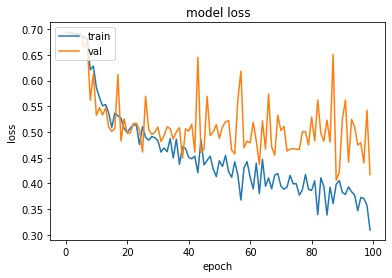

In [124]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

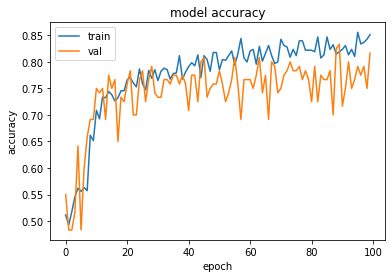

In [123]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
model.save("/content/gdirve/My Drive/Kaggle/model.h5")


In [0]:
!tensorflowjs_converter --input_format keras model.h5 tfjs/model